In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from visualization_toolkit.plots.boxplot import boxplot
from visualization_toolkit.adapters.mse_experiment import mse_experiment
from visualization_toolkit.styles.boxplot import (
    boxprops_filled,
    boxprops_filled_hatched,
)

### Utils

In [2]:
def generate_clean_signals(
    n_signals: int,
    n_samples: int,
    fs: float = 1.0,
):
    t = np.arange(n_samples) / fs
    signals = []

    for _ in range(n_signals):
        x = np.sin(2 * np.pi * 0.05 * t) + 0.5 * np.sin(2 * np.pi * 0.12 * t)
        signals.append(x)

    return np.array(signals)


def add_noise(signal: np.ndarray, ratio: float) -> np.ndarray:
    """
    Adds noise with a specified ratio of signal to noise ratio (sigma_signal / sigma_noise).

    Parameters:
        signal: The original signal.
        ratio: The desired sigma_signal / sigma_noise ratio (for example, 10 = noise 10 times weaker).

    Returns:
        A noisy signal, noise.
    """
    sigma_signal = np.std(signal, ddof=1)
    sigma_noise = sigma_signal / ratio

    noise = np.random.normal(0, sigma_noise, size=signal.shape)

    return signal + noise, noise


def generate_noisy_dataset(
    clean_signals,
    noise_ratios,
):
    original = []
    noisy = []

    for ratio in noise_ratios:
        for signal in clean_signals:
            original.append(signal)
            noisy_signal, _ = add_noise(signal, ratio)
            noisy.append(noisy_signal)

    return np.array(original), np.array(noisy)


def moving_average(x, k):
    return np.convolve(x, np.ones(k) / k, mode="same")

## Usage example

In [3]:
noise_ratios = np.arange(0.1, 1.5, 0.5)
n_realizations = 20
n_samples = 512

In [4]:
clean = generate_clean_signals(
    n_realizations,
    n_samples,
)

original_signals, noisy_signals = generate_noisy_dataset(
    clean,
    noise_ratios,
)

In [5]:
signals = {
    "N": noisy_signals,
    "MA-5": np.array([moving_average(x, 5) for x in noisy_signals]),
    "MA-2": np.array([moving_average(x, 2) for x in noisy_signals]),
}
mse_df = mse_experiment(original_signals, signals, noise_ratios, "noise_ratio")
mse_df["snr"] = 20 * np.log10(mse_df["noise_ratio"])
mse_df["snr"] = mse_df["snr"].round(2)
mse_df.head(-5)

,noise_ratio,mse,label,run,snr
0,0.1,64.735547,N,0,-20.00
1,0.1,60.335175,N,1,-20.00
2,0.1,65.646535,N,2,-20.00
3,0.1,60.235404,N,3,-20.00
4,0.1,56.509581,N,4,-20.00
...,...,...,...,...,...
170,1.1,0.257303,MA-2,10,0.83
171,1.1,0.269896,MA-2,11,0.83
172,1.1,0.257587,MA-2,12,0.83
173,1.1,0.316390,MA-2,13,0.83


In [6]:
styles = {
    "N": boxprops_filled(),
    "MA-2": boxprops_filled(facecolor="white"),
    "MA-5": boxprops_filled_hatched(hatch="||"),
}

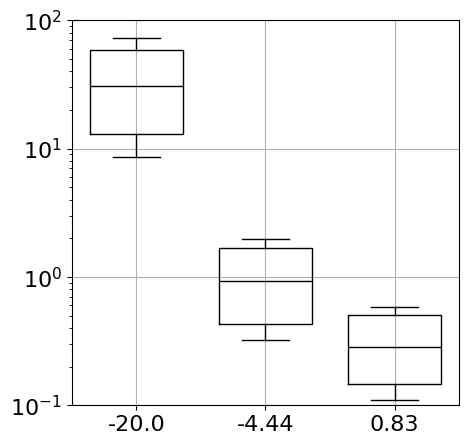

In [7]:
boxplot(mse_df, "snr", "mse", styles=styles, y_limits=((10 ** (-1), 10 ** (2)),), fig_size=(5, 5), medianprops={"color": "black", "linewidth": 1})
plt.show()

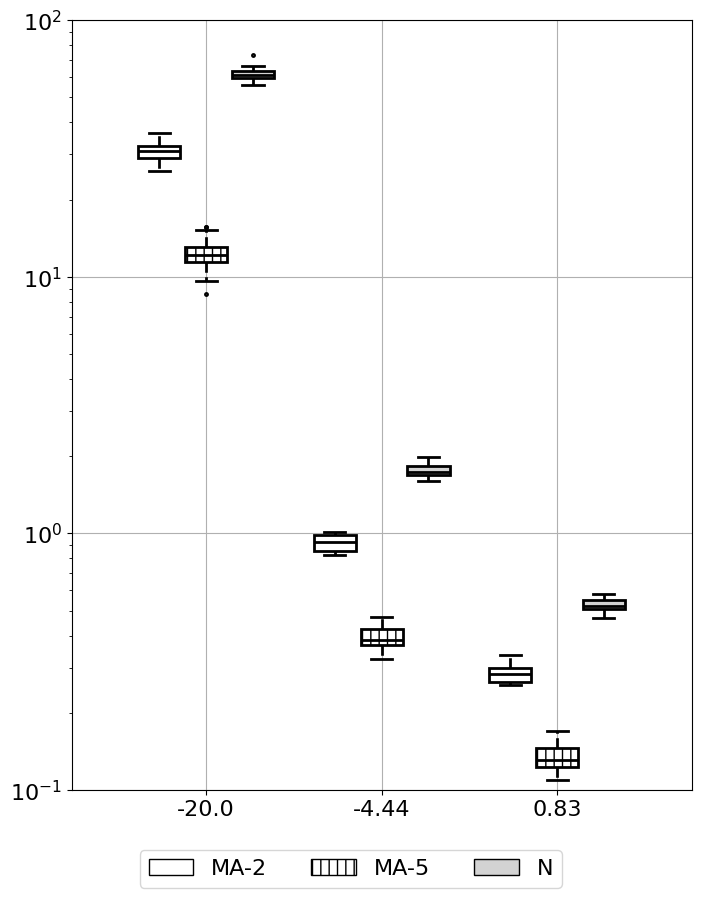

In [8]:
boxplot(mse_df, "snr", "mse", "label", styles=styles, y_limits=((10 ** (-1), 10 ** (2)),), fig_size=(8, 10))
plt.show()

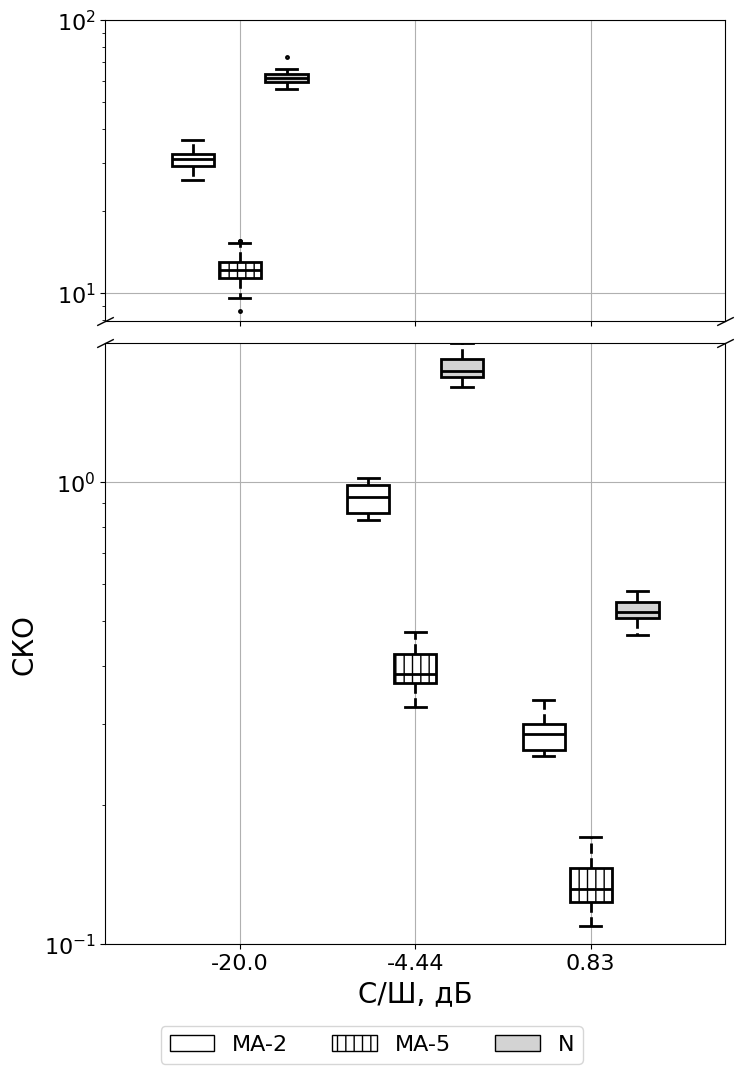

In [9]:
fig, axes = boxplot(
    mse_df,
    "snr",
    "mse",
    "label",
    x_label="С/Ш, дБ",
    y_label="СКО",
    y_limits=((10 ** (-1), 10 ** (0.3)),(10 ** (0.9), 10 ** (2))),
    styles=styles,
    fig_size=(8, 12),
)
plt.show()

### Boxplot with significant level

In [10]:
from visualization_toolkit.plots._significance_boxplot import compare_hue_within_groups, compare_all_pairs

In [11]:
snr_levels = [5, 10, 20]
labels = ["X", "Y", "Z"]
n_repeats = 20

rows = []
for snr in snr_levels:
    for label in labels:
        base = {
            "X": 0.3 + snr * 0.01,
            "Y": 0.5 + snr * 0.01,
            "Z": 0.8 + snr * 0.01
        }[label]
        values = base + 0.15 * np.random.randn(n_repeats)
        for run, v in enumerate(values):
            rows.append({
                "snr": snr,
                "label": label,
                "mse": v,
                "run": run,
                "noise_ratio": 0.1
            })

test_df = pd.DataFrame(rows)

In [12]:
test_df.head()

,snr,label,mse,run,noise_ratio
0,5,X,0.334803,0,0.1
1,5,X,0.201505,1,0.1
2,5,X,0.331629,2,0.1
3,5,X,0.424271,3,0.1
4,5,X,0.480148,4,0.1


In [13]:
compare_hue_within_groups(test_df, "snr", "mse", "label")

,x,hue1,hue2,pvalue
0,5,X,Y,4.680403e-05
1,5,X,Z,6.795615e-08
2,5,Y,Z,6.673651e-06
3,10,X,Y,3.056629e-03
4,10,X,Z,1.430853e-07
5,10,Y,Z,4.540080e-06
6,20,X,Y,4.155022e-04
7,20,X,Z,2.959754e-07
8,20,Y,Z,6.673651e-06


In [14]:
compare_all_pairs(test_df, "snr", "mse")

,x1,x2,pvalue
0,5,10,0.285476
1,5,20,0.005450
2,10,20,0.077368


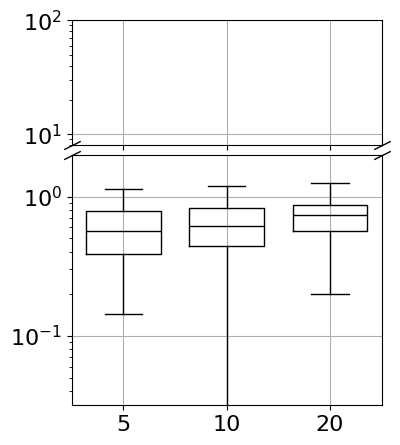

In [15]:
boxplot(
    test_df,
    "snr",
    "mse",
    styles=styles,
    y_limits=((10 ** (-1.5), 10 ** (0.3)),(10 ** (0.9), 10 ** (2))),
    fig_size=(4, 5),
    significance_fn=lambda d: compare_all_pairs(d, "snr", "mse"),
    significance_levels={
        0.001: "***",
        0.01: "**",
        0.05: "*",
    },
    medianprops={"color": "black", "linewidth": 1},
)
plt.show()

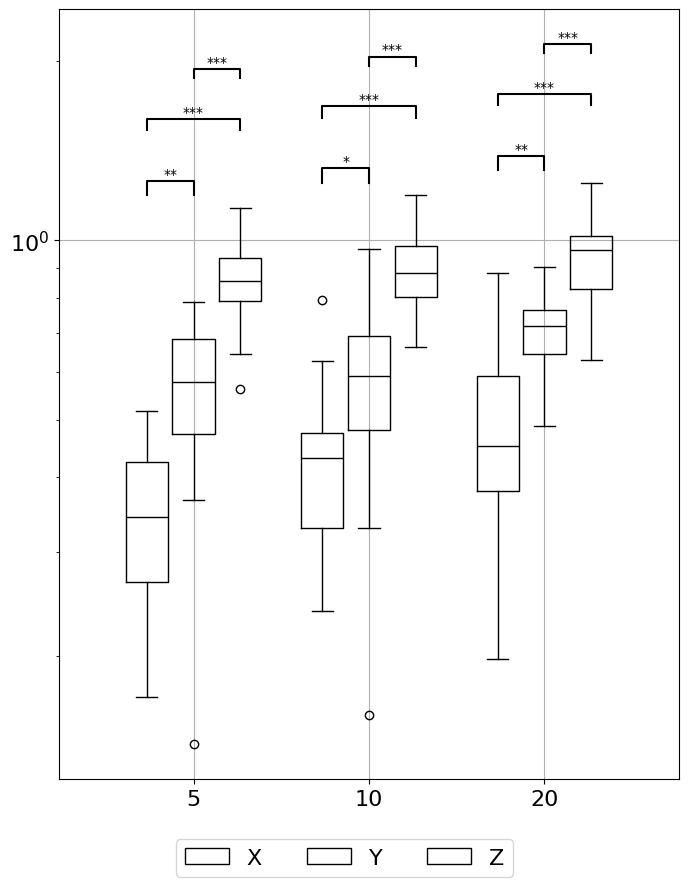

In [16]:
boxplot(
    test_df,
    "snr",
    "mse",
    "label",
    styles=styles,
    fig_size=(8, 10),
    significance_fn=lambda d: compare_hue_within_groups(d, "snr", "mse", "label"),
    significance_levels={
        0.00001: "***",
        0.001: "**",
        0.05: "*",
    },
    medianprops={"color": "black", "linewidth": 1},
)
plt.show()